## LAB CHALLENGE: Neural Matrix Factorization 
In the previous lecture we have built a recommender system using the Neural Matrix Factorization framework. This framework allowed us to combine the GMF layers with the MLP layers in this way:
$$\phi^{GMF} = \mathbf{p_u}^G\odot \mathbf{q_i}^G$$
$$\phi^{MLP} = a_L(\mathbf{W}_L^T(a_{L-1}(...a_2 (\mathbf{W}_2^T \begin{bmatrix}
\mathbf{p_u} \\ \mathbf{q_i}
\end{bmatrix} + \mathbf{b}_2)...)) + \mathbf{b}_L)$$

$$ y_{ui} = \sigma(\mathbf{h}^T \begin{bmatrix}
\ \phi^{GMF} \\ \phi^{MLP}
\end{bmatrix})$$

<center>  <img src="https://drive.google.com/uc?export=view&id=1gNLUpiQdbDPMdvfZYVs3lcou3cd4Favb" width="550" height="400"> </center> 

Let's now try to apply transfer learning to such an architecture. 

- TASK 1: Train the GMF and MLP models separately, inspect and save the parameters.
- TASK 2: Use the pre-trained parameters for initializing the NMF architecture. In particular, use the pre-trained embeddings for users and items and the initialized layers of GMF and MLP.
- TASK 3: Finally, train the NMF model both by freezing the layers preceding the NeuMF layer and by keeping all the parameters trainable. Compare the performance with the network trained from scratch.


In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import time

from neumf import NeuMF
from metrics import metrics
from metrics import loss_function
from NCF_Data import NCF_Data
from torchsummary import summary


## PATH definition

In [2]:
PATH = "./ml-100k/u.data" 
MODEL_PATH = "./models/" 

## Parameters Definition

In [3]:
args = {
    "seed": 42,
    "lr": 0.01,
    "dropout": 0.2,
    "batch_size": 256,
    "epochs": 30,
    "top_k": 10,
    "num_factors": 32,
    "layers": (64, 32, 16, 8),
    "out": True,
    "num_ng": 4,
    "num_ng_test": 100
}

In [4]:
best_config = {
    "lr": 0.01,
    "batch_size": 128,
    "num_factors_gmf": 16,
    "num_factors_mlp": 64,
    "epochs": 30,
    "out": True,
    "dropout": [0, 0, 0, 0],
}

In [5]:
np.random.seed(args["seed"])
torch.manual_seed(args["seed"])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cpu')

## Load Train and Test loaders

In [6]:
# load data
ml_100k = pd.read_csv(
	PATH, 
	sep="\t", 
	names = ['user_id', 'item_id', 'rating', 'timestamp'], 
	engine='python')

# set the num_users, items
num_users = ml_100k['user_id'].nunique()+1
num_items = ml_100k['item_id'].nunique()+1

# construct the train and test datasets
data = NCF_Data(ml_100k, args)
train_loader = data.get_train_instance()
test_loader = data.get_test_instance()

# Models

In [7]:
def train_model(model: nn.Module, train_loader: DataLoader, test_loader: DataLoader):
    model = model.to(device)

    # Loss and optimizer
    loss_function = nn.BCELoss()
    #optimizer = optim.Adam(model.parameters(), lr=args["lr"])
    optimizer = optim.SGD(model.parameters(), lr=args["lr"])

    best_hr = 0
    
    # Train cycle
    for epoch in range(args["epochs"]):
        start_time = time.time()
        
        # Train step
        model.train()

        for user, item, label in train_loader:
            user = user.to(device)
            item = item.to(device)
            label = label.to(device)

            # Zero grad
            optimizer.zero_grad()
            
            # Prediction
            prediction = model(user, item)
            loss = loss_function(prediction, label)
            
            # Backpropagation
            loss.backward()
            optimizer.step()

        # Eval metrics
        model.eval()
        HR, NDCG = metrics(model, test_loader, args["top_k"], device)

        # Print metrics and time elapsed
        elapsed_time = time.time() - start_time
        print(
            "Epoch {:03d}".format(epoch)
            + " time to train: "
            + time.strftime("%H: %M: %S", time.gmtime(elapsed_time))
        )
        print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))

        # If best model, save it
        if HR > best_hr:
            best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
            if args["out"]:
                if not os.path.exists(MODEL_PATH):
                    os.mkdir(MODEL_PATH)
                torch.save(
                    model, "{}{}{}.pt".format(MODEL_PATH, model.__class__.__name__, model.num_factors)
                )


## GMF model

In [9]:
class GMF(nn.Module):
    def __init__(self, num_users, num_items):
        super(GMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = args["num_factors"]

        self.embedding_user = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.num_factors
        )
        self.embedding_item = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.num_factors
        )

        self.affine_output = nn.Linear(in_features=self.num_factors, out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        element_product = torch.mul(user_embedding, item_embedding)
        logits = self.affine_output(element_product)
        rating = self.logistic(logits)
        return rating.squeeze()


In [10]:
#gmf_model = GMF(num_users, num_items)
#train_model(gmf_model, train_loader, test_loader)
gmf_model = torch.load(MODEL_PATH + "GMF8.pt", map_location=device)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

## MLP model

In [ ]:
class MLP(nn.Module):
    def __init__(self, num_users, num_items):
        super(MLP, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = args["num_factors"]

        self.embedding_user = nn.Embedding(
            num_embeddings=num_users, embedding_dim=args["num_factors"]
        )
        self.embedding_item = nn.Embedding(
            num_embeddings=num_items, embedding_dim=args["num_factors"]
        )

        layer_sizes = args["layers"]
        layers = []
        layers.append(nn.Linear(args["num_factors"] * 2, layer_sizes[0]))
        #layers.append(nn.ReLU())
        for in_size, out_size in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.append(nn.Linear(in_size, out_size))
            layers.append(nn.ReLU())
        self.mlp_fc = nn.Sequential(*layers)
        self.mlp_fc.add_module("affine", nn.Linear(layer_sizes[-1], 1))
        self.mlp_fc.add_module("logit", nn.Sigmoid())

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)
        rating = self.mlp_fc(vector)
        return rating.squeeze()


In [ ]:
"""args["lr"] = 0.01
args["dropout"] = 0
args["num_factors"] = 64
args['layers'] = [32, 16, 8]
mlp_model = MLP(num_users, num_items)
train_model(mlp_model, train_loader, test_loader)"""
mlp_model = torch.load(MODEL_PATH + "MLP64.pt", map_location=device)

## NeuMF model

In [ ]:
#nmf_model = torch.load(MODEL_PATH + "Assignment 1 - best.pt", map_location=device)
nmf_model = NeuMF(gmf_model.num_factors, mlp_model.num_factors, num_users, num_items)

# Defining functions that load sub_models weights

In [ ]:
def load_gmf_weights(nmf_model, gmf_model, requires_grad=False):
    nmf_layers_names = [name for name, param in nmf_model.named_parameters()]
    gmf_layers_names = [name for name, param in gmf_model.named_parameters()]
    #create a dict that has as key the value of the layer in the NMF model and as value the layer in the GMF model
    layers_name_match_dict = {k: v for k, v in zip(nmf_layers_names[:2], gmf_layers_names)}
    for nmf_layer_name, gmf_layer_name in layers_name_match_dict.items():
        nmf_model.state_dict()[nmf_layer_name].copy_(gmf_model.state_dict()[gmf_layer_name])
    #deactivate grad for the layers that comes from the GMF model
    for name, param in nmf_model.named_parameters():
        if name in layers_name_match_dict.keys():
            param.requires_grad = requires_grad


def load_mlp_weights(nmf_model, mlp_model, requires_grad=False):
    nmf_layers_names = [name for name, param in nmf_model.named_parameters()]
    mlp_layers_names = [name for name, param in mlp_model.named_parameters()]
    #create a dict that has as key the value of the layer in the NMF model and as value the layer in the MLP model
    layers_name_match_dict = {k: v for k, v in zip(nmf_layers_names[4:], mlp_layers_names[:-2])}
    for nmf_layer_name, mlp_layer_name in layers_name_match_dict.items():
        nmf_model.state_dict()[nmf_layer_name].copy_(mlp_model.state_dict()[mlp_layer_name])
    #deactivate grad for the layers that comes from the MLP model
    for name, param in nmf_model.named_parameters():
        if name in layers_name_match_dict.keys():
            param.requires_grad = requires_grad


def load_pre_trained_weights(nmf_model, gmf_model, mlp_model, requires_grad = False):
    load_gmf_weights(nmf_model, gmf_model, requires_grad)
    load_mlp_weights(nmf_model, mlp_model, requires_grad)

# Performance with sum_models layers freezed

In [ ]:
nmf_model = NeuMF(gmf_model.num_factors, mlp_model.num_factors, num_users, num_items)

In [ ]:
list(nmf_model.named_parameters())[0][1]

Parameter containing:
tensor([[-0.6028,  0.8353, -1.1242,  ...,  0.6681,  0.4443, -0.1775],
        [ 1.7384, -1.8417,  1.4836,  ...,  0.1690, -0.5419, -0.0628],
        [ 0.2150, -1.2996, -0.0402,  ..., -0.8370, -1.0068,  0.2470],
        ...,
        [ 1.3834, -0.5246, -0.5837,  ..., -0.3957, -1.4864, -0.5162],
        [-0.5861, -0.9942, -0.6101,  ...,  0.2123,  0.6600, -0.4486],
        [-0.0791, -0.3824,  0.6556,  ...,  0.7171, -0.2823, -0.2871]],
       requires_grad=True)

In [ ]:
load_pre_trained_weights(nmf_model, gmf_model, mlp_model, requires_grad=False)

In [ ]:
list(nmf_model.named_parameters())[0][1]


Parameter containing:
tensor([[-0.1514,  0.4690,  0.6961,  ...,  0.8707, -0.4645, -0.1457],
        [ 0.2311,  0.8680, -0.6166,  ...,  1.5733, -0.4352,  0.3049],
        [-0.1804,  1.0708,  0.9530,  ...,  0.9818,  1.4919,  0.7378],
        ...,
        [-2.6230,  0.1944, -0.3794,  ..., -0.5907, -0.1775, -0.0250],
        [-0.3618,  1.9552,  0.1007,  ...,  0.6635, -0.0256, -1.0146],
        [-0.4400,  2.0753, -0.6651,  ..., -0.6961,  0.1153,  1.3355]])

In [ ]:
for name, param in nmf_model.named_parameters():
    print(name, param.requires_grad)

gmf_user_embed.0.weight False
gmf_item_embed.0.weight False
gmf_affine.weight True
gmf_affine.bias True
mlp_user_embed.0.weight False
mlp_item_embed.0.weight False
mlp_fc.0.weight False
mlp_fc.0.bias False
mlp_fc.3.weight False
mlp_fc.3.bias False
mlp_fc.6.weight False
mlp_fc.6.bias False
mlp_fc.9.weight False
mlp_fc.9.bias False
mixing_layers.0.weight True
mixing_layers.0.bias True
mixing_layers.3.weight True
mixing_layers.3.bias True
mixing_layers.6.weight True
mixing_layers.6.bias True


In [ ]:
args["lr"]

0.01

In [ ]:
train_model(nmf_model, train_loader, test_loader)

Epoch 000 time to train: 00: 00: 07
HR: 0.619	NDCG: 0.368
Epoch 001 time to train: 00: 00: 07
HR: 0.617	NDCG: 0.373
Epoch 002 time to train: 00: 00: 08
HR: 0.618	NDCG: 0.367
Epoch 003 time to train: 00: 00: 09
HR: 0.618	NDCG: 0.363
Epoch 004 time to train: 00: 00: 09
HR: 0.618	NDCG: 0.359
Epoch 005 time to train: 00: 00: 10
HR: 0.618	NDCG: 0.358
Epoch 006 time to train: 00: 00: 12
HR: 0.617	NDCG: 0.354
Epoch 007 time to train: 00: 00: 11
HR: 0.620	NDCG: 0.357
Epoch 008 time to train: 00: 00: 09
HR: 0.618	NDCG: 0.357
Epoch 009 time to train: 00: 00: 10
HR: 0.617	NDCG: 0.356
Epoch 010 time to train: 00: 00: 10
HR: 0.616	NDCG: 0.356
Epoch 011 time to train: 00: 00: 10
HR: 0.618	NDCG: 0.358
Epoch 012 time to train: 00: 00: 10
HR: 0.620	NDCG: 0.362
Epoch 013 time to train: 00: 00: 10
HR: 0.620	NDCG: 0.362
Epoch 014 time to train: 00: 00: 09
HR: 0.625	NDCG: 0.365
Epoch 015 time to train: 00: 00: 10
HR: 0.627	NDCG: 0.365
Epoch 016 time to train: 00: 00: 10
HR: 0.628	NDCG: 0.364
Epoch 017 time

# Performance letting initialized layers free

In [ ]:
nmf_model = NeuMF(gmf_model.num_factors, mlp_model.num_factors, num_users, num_items)
load_pre_trained_weights(nmf_model, gmf_model, mlp_model, requires_grad=True)
for name, param in nmf_model.named_parameters():
    print(name, param.requires_grad)

gmf_user_embed.0.weight True
gmf_item_embed.0.weight True
gmf_affine.weight True
gmf_affine.bias True
mlp_user_embed.0.weight True
mlp_item_embed.0.weight True
mlp_fc.0.weight True
mlp_fc.0.bias True
mlp_fc.3.weight True
mlp_fc.3.bias True
mlp_fc.6.weight True
mlp_fc.6.bias True
mlp_fc.9.weight True
mlp_fc.9.bias True
mixing_layers.0.weight True
mixing_layers.0.bias True
mixing_layers.3.weight True
mixing_layers.3.bias True
mixing_layers.6.weight True
mixing_layers.6.bias True


In [ ]:
train_model(nmf_model, train_loader, test_loader)

Epoch 000 time to train: 00: 00: 10
HR: 0.638	NDCG: 0.385
Epoch 001 time to train: 00: 00: 12
HR: 0.631	NDCG: 0.378
Epoch 002 time to train: 00: 00: 15
HR: 0.654	NDCG: 0.387
Epoch 003 time to train: 00: 00: 15
HR: 0.646	NDCG: 0.382
Epoch 004 time to train: 00: 00: 14
HR: 0.645	NDCG: 0.375
Epoch 005 time to train: 00: 00: 14
HR: 0.656	NDCG: 0.379
Epoch 006 time to train: 00: 00: 13
HR: 0.657	NDCG: 0.382
Epoch 007 time to train: 00: 00: 14
HR: 0.633	NDCG: 0.373
Epoch 008 time to train: 00: 00: 13
HR: 0.642	NDCG: 0.378
Epoch 009 time to train: 00: 00: 14
HR: 0.638	NDCG: 0.376
Epoch 010 time to train: 00: 00: 14
HR: 0.632	NDCG: 0.370
Epoch 011 time to train: 00: 00: 14
HR: 0.639	NDCG: 0.371
Epoch 012 time to train: 00: 00: 14
HR: 0.629	NDCG: 0.368
Epoch 013 time to train: 00: 00: 14
HR: 0.635	NDCG: 0.372
Epoch 014 time to train: 00: 00: 14
HR: 0.626	NDCG: 0.369
Epoch 015 time to train: 00: 00: 14
HR: 0.628	NDCG: 0.362
Epoch 016 time to train: 00: 00: 14
HR: 0.624	NDCG: 0.370
Epoch 017 time

# Performance comparison

In [ ]:
nmf_freezed = torch.load(MODEL_PATH + "NeuMF64-freezed.pt", map_location = device)
gmf_best = torch.load(MODEL_PATH + "GMF8.pt", map_location = device)
mlp_best = torch.load(MODEL_PATH + "MLP64.pt", map_location = device)
nmf_free = torch.load(MODEL_PATH + "NeuMF64-free.pt", map_location = device)
nmf_init = torch.load(MODEL_PATH + "Assignment 1 - best.pt", map_location = device)

nmf_freezed.to(device) 
gmf_best.to(device) 
mlp_best.to(device)
nmf_free.to(device) 
nmf_init.to(device)

HR, NDCG = {}, {}
HR['NeuMF - freezed'], NDCG['NeuMF - freezed'] = metrics(nmf_freezed, test_loader, 10, device)
HR['NeuMF - free'], NDCG['NeuMF - free'] = metrics(nmf_free, test_loader, 10, device)
HR['NeuMF - init'], NDCG['NeuMF - init'] = metrics(nmf_init, test_loader, 10, device)
HR['GMF'], NDCG['GMF'] = metrics(gmf_best, test_loader, 10, device)
HR['MLP'], NDCG['MLP'] = metrics(mlp_best, test_loader, 10, device)

Text(0.5, 1.0, 'Best NDCG across models')

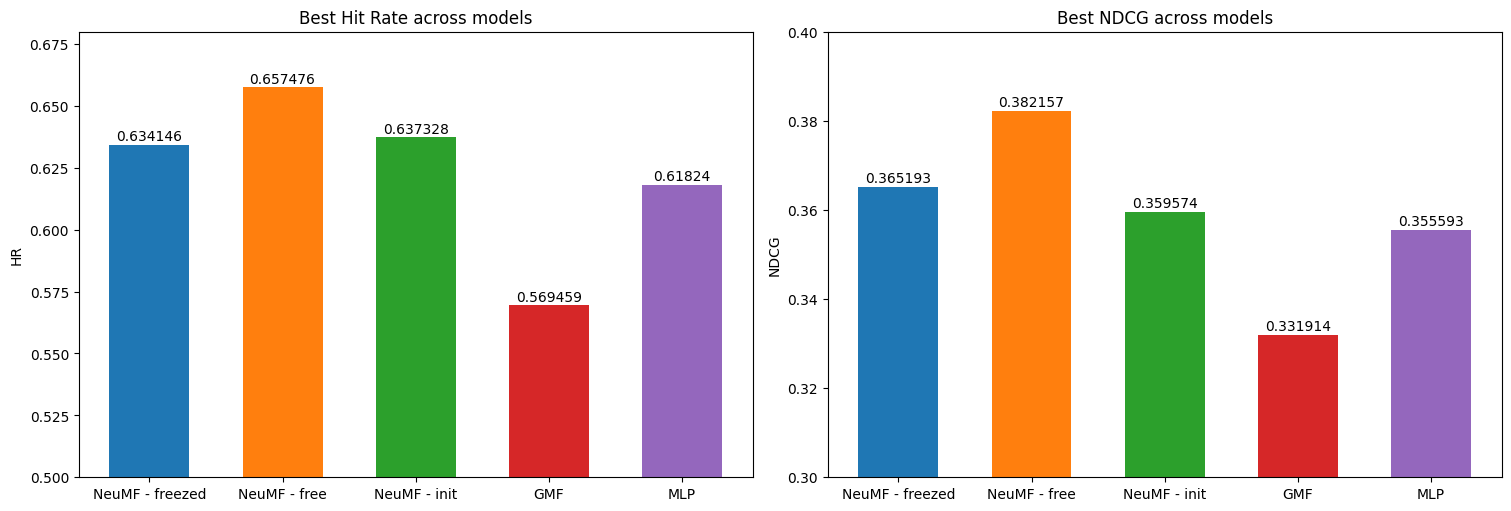

In [ ]:
fig, ax = plt.subplots(1, 2, layout = "constrained", figsize = (15, 5))
for model, value in HR.items():
    rect = ax[0].bar(model, value, width= 0.6)
    ax[0].bar_label(rect, padding = 1)

ax[0].set_ylabel("HR")
ax[0].set_ylim(0.5, 0.68)
ax[0].set_title("Best Hit Rate across models")

for model, value in NDCG.items():
    rect = ax[1].bar(model, value, width= 0.6)
    ax[1].bar_label(rect, padding = 1)

ax[1].set_ylabel("NDCG")
ax[1].set_ylim(0.3, 0.40)
ax[1].set_title("Best NDCG across models")